# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

def get_train_val(X, Y, val_size,random=True):
  n = X.shape[0]
  size = np.int(val_size*n)
  if random:
    val = np.random.choice(n, size=size, replace=False)
    train = np.setdiff1d(np.arange(len(X)), val, assume_unique=True)
  else:
    l = np.arange(n)
    train = l[:n-size]
    val= l[n-size:]
  return X[train],Y[train],X[val],Y[val]

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [ ]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def get_kernel(train_X,test_X,kernel_type,kernel_param):
    num_test = test_X.shape[0]
    num_train = train_X.shape[0]
    if kernel_type=='linear':
        return np.matmul(train_X,(test_X.T))  # (num_train x num_feat) x (num_feat x num_test)
    if kernel_type=='poly':
        return (1+np.matmul(train_X,(test_X.T)))**kernel_param
    if kernel_type=='rbf':
        K = np.zeros((num_train,num_test))
        for i in range(num_test):
            temp = np.sum((train_X-test_X[i,:])**2,axis=1)
            temp = (-1*kernel_param/2)*temp
            K[:,i] = np.exp(temp)
        return K

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., 
                                   kernel_param=1., num_iter_gd=100,eta=0.0001):
    n = X.shape[0]
    d = X.shape[1]
    alpha = np.random.rand(n)
    K = get_kernel(X,X,kernel,kernel_param)
    # print(type(K))
    B = -1*(K*(Y.T))
    for i in range(num_iter_gd):
        temp = sigmoid(np.matmul((alpha.T),(B)))
        grad_R_alpha = np.matmul(B,temp.T)+ reg_param*(np.matmul(K,alpha))
        alpha = alpha - eta*grad_R_alpha
    return alpha

def test_pred(alpha,train_X, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    K_test = get_kernel(train_X,test_X,kernel,kernel_param)
    temp = np.matmul(alpha.T,K_test)
    y_test = np.zeros(np.shape(temp))
    y_test[temp>=0] = 1
    y_test[temp<0] = -1
    return y_test

In [ ]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 
def get_result(train_X, train_Y, test_X,test_Y,kernel,kernel_param,reg_param,eta = 0.0001):
    alpha = train_pred_logistic_regression(train_X, train_Y, kernel=kernel, reg_param=reg_param, 
                                   kernel_param=kernel_param,eta = eta)
    result = test_pred(alpha, train_X, test_X, kernel, kernel_param)
    num_wrong = (result!=test_Y).sum()
    return num_wrong

## getting params for one particular dataset, one particular kernel type - with all kernel, reg param lists
def get_params(train_X, train_Y, test_X,test_Y,kernel,kernel_param_list,reg_param_list):
    k = len(kernel_param_list)
    r = len(reg_param_list)
    errors=np.zeros((k,r))
    for i in range(k):
        for j in range(r):
            errors[i,j] = get_result(train_X, train_Y, test_X,test_Y,kernel,kernel_param_list[i],reg_param_list[j])
    kernel_param_best, reg_param_best = np.argwhere(errors == np.min(errors))[-1]
    return [kernel_param_list[kernel_param_best], reg_param_list[reg_param_best]]

def get_eta(train_X,train_Y,test_X, test_Y,kernel,kernel_param, reg_param):
    etas = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
    errors = np.zeros(len(etas))
    for i in range(len(etas)):
        errors[i] = get_result(train_X, train_Y, test_X,test_Y,kernel,kernel_param,reg_param,eta = etas[i])
    # print(kernel, errors)
    index = np.argwhere(errors == np.min(errors))[-1]
    return etas[index[0]]
    
def get_params_for_all_kernels_for_dataset(dataset):
    data =   np.load(dataset)
    X = data['arr_0']
    Y = data['arr_1']
    train_X,train_Y,val_X,val_Y = get_train_val(X,Y,0.2)
   
    reg_params = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
    
    lin_kernel_params = [1]
    poly_kernel_params = [1,2,3,4]
    rbf_kernel_params = [1e-5,1e-4,1e-3,1e-2,1e-1,1]
    
    lin_params = get_params(train_X, train_Y, val_X,val_Y,"linear",lin_kernel_params,reg_params)
    poly_params = get_params(train_X, train_Y, val_X,val_Y,"poly",poly_kernel_params,reg_params)
    rbf_params = get_params(train_X, train_Y, val_X,val_Y,"rbf",rbf_kernel_params,reg_params)
    
    lin_eta = get_eta(train_X,train_Y,val_X, val_Y,"linear",lin_params[0], lin_params[1])
    poly_eta = get_eta(train_X,train_Y,val_X, val_Y,"poly",poly_params[0], poly_params[1])
    rbf_eta = get_eta(train_X,train_Y,val_X, val_Y,"rbf",rbf_params[0], rbf_params[1])
    l = np.array([lin_params, poly_params, rbf_params])
    e = np.array([lin_eta, poly_eta, rbf_eta])
    # print("this is e",e)
    return l.T,e

datasets = ["../../Data/dataset_A.npz","../../Data/dataset_B.npz","../../Data/dataset_C.npz","../../Data/dataset_D.npz"]
kernel_param_table = np.zeros((4,3))
reg_param_table = np.zeros((4,3))
eta_table = np.zeros((4,3))

for i in range(len(datasets)):
    hyperparams, etas= get_params_for_all_kernels_for_dataset(datasets[i])
    kern,reg = hyperparams
    kernel_param_table[i,:] = kern
    reg_param_table[i,:] = reg
    eta_table[i,:] = etas

    # for each dataset, for each model. 4X3
def get_train_test_accuracy(dataset,i):
     
     data = np.load(dataset)
     train_X = data['arr_0']
     train_Y = data['arr_1']
     test_X = data['arr_2']
     test_Y = data['arr_3']
     final_table = np.empty((3,1))
     print(dataset)
     print()
     print('Kernel|Kernel_param|Reg_param|Learning_Rate|Train_accuracy|Test_Accuracy')
     print('---|---|----|---|---|---')
     kernel = ["linear","poly","rbf"] 
     for j in range(len(kernel)):
        kernel_param = kernel_param_table[i,j]
        reg_param = reg_param_table[i,j]
        eta = eta_table[i,j]
        alpha = train_pred_logistic_regression(train_X, train_Y, kernel=kernel[j], reg_param=reg_param, 
                                      kernel_param=kernel_param,eta = eta)
        train_result = test_pred(alpha, train_X, train_X, kernel[j], kernel_param)
        test_result = test_pred(alpha, train_X, test_X, kernel[j], kernel_param)
        train_accuracy = (train_result==train_Y).sum()/train_result.shape[0]
        test_accuracy = (test_result==test_Y).sum()/test_result.shape[0]
        print("{} | {} | {} | {} | {:.2f} | {:.2f} ".format(kernel[j],kernel_param,reg_param,eta,train_accuracy,test_accuracy))
     print('\n-------------------------------------')
# get_train_test_accuracy("dataset_A.npz",0)
# get_train_test_accuracy("dataset_B.npz",1)
# get_train_test_accuracy("dataset_C.npz",2)
# get_train_test_accuracy("dataset_D.npz",3)

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  

dataset_A.npz

Kernel|Kernel_param|Reg_param|Learning_Rate|Train 0/1 error|Test 0/1 error
---|---|----|---|---|---
linear | 1.0 | 1e-05 | 0.1 | 0.21 | 0.19
poly | 2.0 | 1e-06 | 1.0 | 0.14 | 0.15 
rbf | 1.0 | 1.0 | 0.0001 | 0.10 | 0.11

-------------------------------------
dataset_B.npz

Kernel|Kernel_param|Reg_param|Learning_Rate|Train 0/1 error|Test 0/1 error
---|---|----|---|---|---
linear | 1.0 | 0.1 | 1e-05 | 0.18 | 0.20 
poly | 3.0 | 0.0001 | 1e-05 | 0.19 | 0.21 
rbf | 1.0 | 0.01 | 0.001 | 0.25 | 0.28 

-------------------------------------
dataset_C.npz

Kernel|Kernel_param|Reg_param|Learning_Rate|Train 0/1 error|Test 0/1 error
---|---|----|---|---|---
linear | 1.0 | 1e-06 | 1e-07 | 0.48 | 0.49
poly | 1.0 | 1e-06 | 1e-07 | 0.48 | 0.50 
rbf | 0.001 | 1e-05 | 0.1 | 0.22 | 0.26 

-------------------------------------
dataset_D.npz

Kernel|Kernel_param|Reg_param|Learning_Rate|Train 0/1 error|Test 0/1 error
---|---|----|---|---|---
linear | 1.0 | 0.01 | 0.0001 | 0.43 | 0.23 
poly | 1.0 | 0.01 | 0.0001 | 0.43 | 0.23 
rbf | 1e-05 | 10.0 | 0.0001 | 0.15 | 0.08 

-------------------------------------
-------------------------------------
__Observations__  
1) We notice that datasetA can be separated however there is no linear boundary that can achieve this separation, hence we observe that rbf and poly kernels perform very well. However, due to the nature of the dataset, even though linear kernels do not achieve a good boundary, the error is not very high, since, the majority of the points lie in distinct areas  
2) In DatasetB we notice that even though there is a separation among the majority of points, there is a lot of overlap among them. Most of the kernels resort to linear-ish boundaries and all kernels have the same accuracy  
3) DatasetC appears to have a non-linear boundary of separation since poly and rbf kernels outperform.  
4) DatasetD appears to have a linear boundary of separation and linear kernel outperforms  
5) In most of the datasets [all except datasetB] we notice that reg_param of rbf >= reg_param of other two. This tells us that RBF has the highest tendency to overfit and requires very strong regularization to counter that.  
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


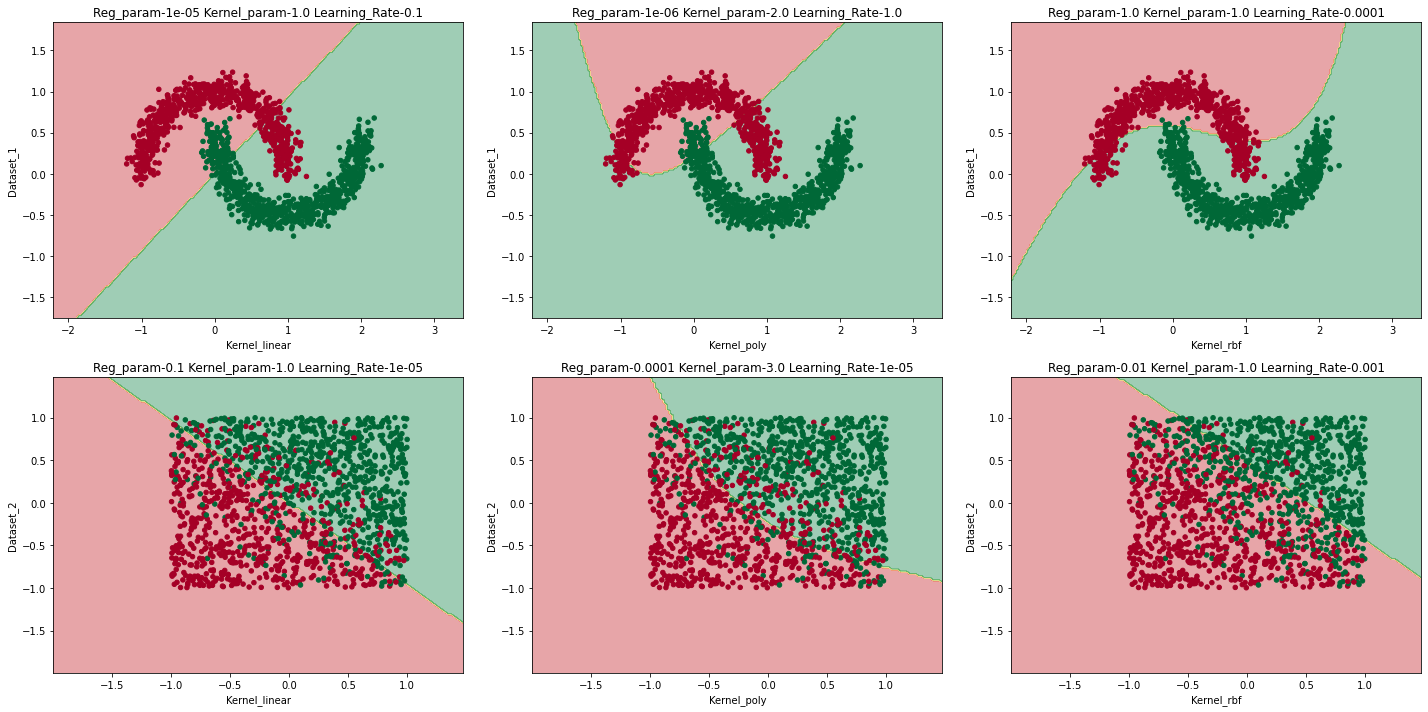

In [ ]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
def plot(X_train,Y_train, kernel,kernel_param,reg_param,eta,axes,i,j):
    x_min, x_max = X_train[:, 0].min()-1, 1.5*X_train[:, 0].max()
    y_min, y_max = X_train[:, 1].min()-1, 1.5*X_train[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.025),
                     np.arange(y_min, y_max, 0.025))
    alpha = train_pred_logistic_regression(X_train, Y_train, kernel=kernel, reg_param=reg_param, 
                                           kernel_param=kernel_param, num_iter_gd=100,eta=eta)

    Z = test_pred(alpha, X_train, np.c_[xx.ravel(), yy.ravel()], kernel, kernel_param)
    Z = Z.reshape(xx.shape)

    axes[i][j].contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    axes[i][j].scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap="RdYlGn",
                              s=20)
    axes[i][j].set_xlabel("Kernel_{}".format(kernel))
    axes[i][j].set_ylabel("Dataset_{}".format(i+1))
    axes[i][j].set_title("Reg_param-{} Kernel_param-{} Learning_Rate-{}".format(reg_param,kernel_param,eta))


def output_data(dataset,axes,i):
    data =   np.load(dataset)
    X = data['arr_0']
    Y = data['arr_1']
    rows, columns = X.shape
    kernel = ["linear","poly","rbf"]

    for j in range(3):
        kernel_param = kernel_param_table[i,j]
        reg_param = reg_param_table[i,j]
        eta = eta_table[i,j]
        plot(X,Y, kernel[j],kernel_param,reg_param,eta,axes,i,j)

fig,axes = plt.subplots(2,3,figsize=(20,10))  
output_data("../../Data/dataset_A.npz",axes,0)
output_data("../../Data/dataset_B.npz",axes,1)
plt.tight_layout()
plt.show()


# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [ ]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here
def train_SVM(X, Y, kernel='linear', reg_param=1,kernel_param=1):
    if kernel =="rbf":
        try:
            svc = svm.SVC(C=reg_param, kernel="rbf",gamma=kernel_param)
        except: 
            svc = svm.SVC(C=reg_param, kernel="rbf")
    else: 
        svc = svm.SVC(C=reg_param, kernel=kernel, degree=kernel_param)
    classifier = svc.fit(X,Y)
    return classifier
def test_SVM(test_X, classifier):
    pred = classifier.predict(test_X)
    return pred

In [ ]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.
def get_result(train_X, train_Y, test_X,test_Y,kernel,kernel_param,reg_param):
    clf = train_SVM(train_X, train_Y, kernel=kernel, reg_param=reg_param, kernel_param=kernel_param)
    result = test_SVM(test_X, clf)
    num_wrong = (result!=test_Y).sum()
    return num_wrong

def get_params(train_X, train_Y, test_X,test_Y,kernel,kernel_param_list,reg_param_list):
    k = len(kernel_param_list)
    r = len(reg_param_list)
    errors =np.zeros((k,r))
    for i in range(k):
        for j in range(r):
            errors[i,j] = get_result(train_X, train_Y, test_X,test_Y,kernel,kernel_param_list[i],reg_param_list[j])
    kernel_param_best, reg_param_best = np.argwhere(errors == np.min(errors))[0]
    return [kernel_param_list[kernel_param_best], reg_param_list[reg_param_best]]

def get_params_for_all_kernels_for_dataset(dataset):
    data =   np.load(dataset)
    X = data['arr_0']
    Y = data['arr_1']
    rows, columns = X.shape
    train_X,train_Y,val_X,val_Y = get_train_val(X,Y,0.2,random=False)
    
    reg_params = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]
    
    lin_kernel_params = [1]
    poly_kernel_params = [1,2,3,4]
    rbf_kernel_params = [1e-5,1e-4,1e-3,1e-2,1e-1,1]
    
    lin_params = get_params(train_X, train_Y, val_X,val_Y,"linear",lin_kernel_params,reg_params)
    poly_params = get_params(train_X, train_Y, val_X,val_Y,"poly",poly_kernel_params,reg_params)
    rbf_params = get_params(train_X, train_Y, val_X,val_Y,"rbf",rbf_kernel_params,reg_params)
    
    l = np.array([lin_params, poly_params, rbf_params])
    return l.T
datasets = ["../../Data/dataset_A.npz","../../Data/dataset_B.npz","../../Data/dataset_C.npz","../../Data/dataset_D.npz"]
kernel_param_table = np.zeros((4,3))
reg_param_table = np.zeros((4,3))

for i in range(len(datasets)):
    kern, reg= get_params_for_all_kernels_for_dataset(datasets[i])
    kernel_param_table[i,:] = kern
    reg_param_table[i,:] = reg
    
def get_train_test_accuracy(dataset,i):
     
     data =   np.load(dataset)
     train_X = data['arr_0']
     train_Y = data['arr_1']
     test_X = data['arr_2']
     test_Y = data['arr_3']
     final_table = np.empty((3,1))
     print(dataset)
     print()
     print('Kernel|Kernel_param|Reg_param|Train_accuracy|Test_Accuracy')
     print('---|---|---|---|---')
     kernel = ["linear","poly","rbf"] 
     for j in range(len(kernel)):
        kernel_param = kernel_param_table[i,j]
        reg_param = reg_param_table[i,j]
        eta = eta_table[i,j]
        classifier = train_SVM(train_X, train_Y, kernel=kernel[j], reg_param=reg_param,kernel_param=kernel_param)
        train_result = test_SVM(train_X, classifier)
        test_result = test_SVM(test_X, classifier)
        train_accuracy = (train_result==train_Y).sum()/train_result.shape[0]
        test_accuracy = (test_result==test_Y).sum()/test_result.shape[0]
        print("{} | {} | {} | {:.2f} | {:.2f} ".format(kernel[j],kernel_param,reg_param,train_accuracy,test_accuracy))
     print('\n-------------------------------------\n')
# get_train_test_accuracy("dataset_A.npz",0)
# get_train_test_accuracy("dataset_B.npz",1)
# get_train_test_accuracy("dataset_C.npz",2)
# get_train_test_accuracy("dataset_D.npz",3)

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  

dataset_A.npz

Kernel|Kernel_param|Reg_param|Train_accuracy|Test_Accuracy
---|---|---|---|---
linear | - | 1.0 | 0.13 | 0.13 
poly | 3.0 | 0.1 | 0.06 | 0.08
rbf | 0.1 | 100.0 | 0.00 | 0.00 

-------------------------------------

dataset_B.npz

Kernel|Kernel_param|Reg_param|Train 0/1 error|Test0/1 error
---|---|---|---|---
linear | - | 1.0 | 0.18 | 0. 21
poly | 1.0 | 1.0 | 0.18 | 0.21 
rbf | 0.01 | 10.0 | 0.18 | 0.20

-------------------------------------

dataset_C.npz

Kernel|Kernel_param|Reg_param|Train 0/1 error|Test 0/1 error
---|---|---|---|---
linear | - | 0.0001 | 0.09 | 0.11 
poly | 4.0 | 10.0 | 0 | 0.04
rbf | 0.001 | 10.0 | 0 | 0.02 

-------------------------------------

dataset_D.npz

Kernel|Kernel_param|Reg_param|Train 0/1 error|Test 0/1 error
---|---|---|---|---
linear | - | 1.0 | 0.03 | 0.05 
poly | 1.0 | 0.1 | 0.12 | 0.07 
rbf | 0.0001 | 10.0 | 0.03 | 0.07

-------------------------------------

__Observations__  
1) We notice that datasetA can be separated however there is no linear boundary that can achieve this separation, hence we observe that rbf and poly kernels perform very well. However, due to the nature of the dataset, even though linear kernels do not achieve a good boundary, the error in not very high, since, the majority of the points lie in distinct areas  
2) In DatasetB we notice that even though there is a separation among the majority of points, there is a lot of overlap among them. Most of the kernels resort to linear-ish boundaries and all kernels have the same accuracy  
3) DatasetC appears to have a non-linear boundary of separation since poly and rbf kernels outperform.  
4) DatasetD appears to have a linear boundary of separation and linear kernel outperforms  
5) In all the datasets we notice that reg_param of rbf >= reg_param of other two. This tells us that RBF has the highest tendency to overfit and requires very strong regularization to counter that.  
6) We also notice that apart from datasetD, training accuracy>=test accuracy. This does not hold for DatasetD in Q1 and Q2.
7) Due to randomness in choosing validation set (which is used to pick hyperparameters, on running multiple times we may observe different boundaries, however this change for SVM if far lesser than the change observed in Logistic regression
__Difference in boundaries between Logistic regression and SVM__  
1) We notice that SVM tends to fit the datasets better than Logistic regression. Thus accuracies in SVM case are better than that of LR.
2) further the best kernel parameters do not match for the two cases except for datasetD.   
3) We can loosely say that SVM requires higher reg_param than Logistic regression which tells us that it is easier to overfit with SVM than with logistic regression  

============================================================================


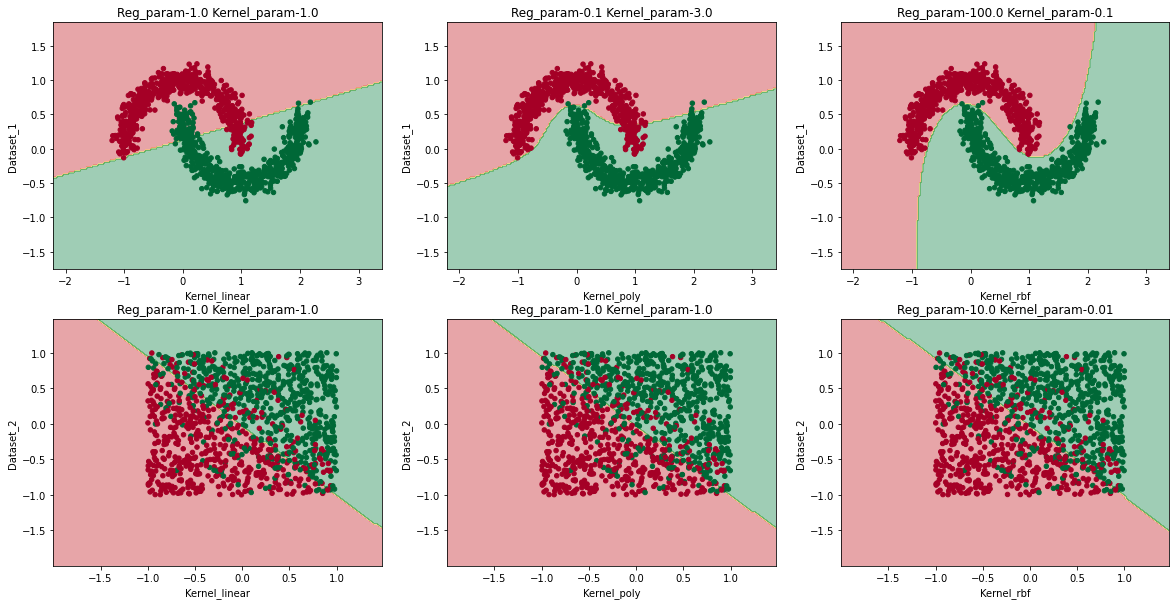

In [ ]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
def plot(X_train,Y_train, kernel,kernel_param,reg_param,axes,i,j):

    x_min, x_max = X_train[:, 0].min()-1, 1.5*X_train[:, 0].max()
    y_min, y_max = X_train[:, 1].min()-1, 1.5*X_train[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.025),
                     np.arange(y_min, y_max, 0.025))
    clf = train_SVM(X_train, Y_train, kernel=kernel, reg_param=reg_param, kernel_param=kernel_param)
    Z = test_SVM(np.c_[xx.ravel(), yy.ravel()], clf)
    Z = Z.reshape(xx.shape)
    
    axes[i][j].contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    axes[i][j].scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap="RdYlGn",
                              s=20)
    axes[i][j].set_xlabel("Kernel_{}".format(kernel))
    axes[i][j].set_ylabel("Dataset_{}".format(i+1))
    axes[i][j].set_title("Reg_param-{} Kernel_param-{}".format(reg_param,kernel_param))

def output_data(dataset,axes,i):
    data =   np.load(dataset)
    X = data['arr_0']
    Y = data['arr_1']
    rows, columns = X.shape
    train = (int) (0.8 * rows)
    train_X = X[:train,]
    train_Y = Y[:train]
    test_X = X[train:,]
    test_Y = Y[train:]
    kernel = ["linear","poly","rbf"]
    
    for j in range(3):
        kernel_param = kernel_param_table[i,j]
        reg_param = reg_param_table[i,j]
        plot(train_X,train_Y, kernel[j],kernel_param,reg_param,axes,i,j)

fig,axes = plt.subplots(2,3,figsize=(20,10))  
output_data("../../Data/dataset_A.npz",axes,0)
output_data("../../Data/dataset_B.npz",axes,1)
plt.show()

# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [ ]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)
def check_purity(data):
    label_column=data[:,-2]
    unique_classes=np.unique(label_column)
    if unique_classes.shape[0]==1:
        return True
    else: 
        return False

def classify_data(data):
    #data is a numpy array with the last column being the label(+1/-1)
    n = data[data[:,-2]==-1]
    p = data[data[:,-2]==1]
    if(p.shape[0]>n.shape[0]):
        return 1
    else:
        return -1
    
def calculate_potential_splits(data):
    potential_splits={}
    n_columns=data.shape[1]-2
    for column_index in range(n_columns):
        values=data[:,column_index]
        max_values=np.max(values)
        min_values=np.min(values)
        diff=(max_values-min_values)/50
        potential_splits[column_index]=[]
        for i in range(1,50):
            split=min_values+diff*i
            potential_splits[column_index].append(split)
    return potential_splits

def split_data(data,feature,threshold):
    feature_column_values=data[:,feature]
    left=data[feature_column_values<=threshold]
    right=data[feature_column_values>threshold]
    return left,right

def calculate_accuracy(left,right):
    wt_vec_left=left[:,-1]
    wt_vec_right=right[:,-1]
    wt_lp=np.sum(wt_vec_left[left[:,-2]==1])
    wt_ln=np.sum(wt_vec_left[left[:,-2]==-1])
    wt_rp=np.sum(wt_vec_right[right[:,-2]==1])
    wt_rn=np.sum(wt_vec_right[right[:,-2]==-1])
    if wt_lp+wt_ln ==0:#case where the left node is does not have any data points
        return max(wt_rp,wt_rn)/(wt_rp+wt_rn)
    elif wt_rp+wt_rn ==0:#case where the  right node does not have any data points
        return max(wt_lp,wt_ln)/(wt_lp+wt_ln)
    else:#case where 
        a = (wt_rp+wt_ln)/(wt_rp+wt_rn+wt_lp+wt_ln)
    accuracy=max(1-a,a)
    return(accuracy)

def calculate_entropy(data):
    #data is a numpy array in which the last column is the label
    wt_vec=data[:,-1]
    wt_pos_vec=wt_vec[data[:,-2]==1]
    wt_neg_vec=wt_vec[data[:,-2]==-1]
    pos_wt=np.sum(wt_pos_vec)
    neg_wt=np.sum(wt_neg_vec)
    if pos_wt==0 or neg_wt==0:
        return 0
    else:
        p = pos_wt/(pos_wt+neg_wt) 
        entropy = (p*np.log(1/p)+(1-p)*np.log((1/(1-p))))
        return (entropy)
           
def calculate_overall_entropy(left,right):
    n=left.shape[0]+right.shape[0]
    entropy=calculate_entropy(left)*(left.shape[0]/n)+calculate_entropy(right)*(right.shape[0]/n)
    return(entropy)

def calculate_best_split(data,potential_splits,criterion='accuracy'):
    #Here potential_splits is a dictionary with key being the feature on which to split. The value corresponding to the key is a list of potential splits values
    min_entropy=1e9
    max_accuracy=-1e9
    for column_index in list(potential_splits.keys()):
        for value in potential_splits[column_index]:
            left,right=split_data(data,column_index,value)
            if criterion=='entropy':
                entropy=calculate_overall_entropy(left,right)  
                if entropy<min_entropy:
                    min_entropy=entropy
                    feature=column_index
                    threshold=value
            elif criterion=='accuracy':
                accuracy=calculate_accuracy(left,right)
                if accuracy>max_accuracy:
                    accuracy=max_accuracy
                    feature=column_index
                    threshold=value
        
    return(feature,threshold)


def  decision_tree_algorithm(data,min_num_nodes=1,counter=0,criterion='accuracy'):
#     print(data.shape)
    
    #base case
#     print(min_num_nodes)
    if check_purity(data) or data.shape[0]<=min_num_nodes:
        classification=classify_data(data)
        return(classification)
    #recursive part
    else:
        counter+=1
        #helper functions
        potential_splits=calculate_potential_splits(data)
        feature,threshold=calculate_best_split(data,potential_splits,criterion)
        left,right=split_data(data,feature,threshold)
        #recursive part
        #print(feature)
        #print(threshold)
        node={'feature':feature, 'threshold':threshold,'left': 'none', 'right':'none'}
        
        if left.shape[0]==data.shape[0] or left.shape[0]==0:
            return
        right_tree=decision_tree_algorithm(right,criterion=criterion,min_num_nodes=min_num_nodes)
        left_tree=decision_tree_algorithm(left,criterion=criterion,min_num_nodes=min_num_nodes)
        
        #if right_tree==left_tree:
         #   node=left_tree
        #else:    
        node['left']=left_tree
        node['right']=right_tree
        return(node)
    
def fit_decision_tree(X,Y,criterion = 'accuracy',min_num_nodes=1,wt_vec='none'):
    if wt_vec=='none':
        wt_vec=np.ones((X.shape[0],1))
    n_data_points = X.shape[0]
    train_data = np.concatenate((X,Y.reshape(n_data_points,1)),axis=1)
    train_data=np.hstack((train_data,wt_vec))#The weight vector is being added as the last column in train array.
    tree=decision_tree_algorithm(train_data,criterion=criterion,min_num_nodes=min_num_nodes)
    return tree
def predict(node,row):
  
  try:
    index = node['feature']
    if row[index] >= node['threshold']:
        if isinstance(node['right'], int):
            return node['right'] 
        else:
            return predict(node['right'], row)
    else:
        if isinstance(node['left'], int):
            return node['left']
        else:
            return predict(node['left'], row)
  except:
    pass

   
def decision_tree_classifier(tree, X_test):
   """ Takes in a tree, and a bunch of instances X and 
   returns the tree predicted values at those instances."""
   Y_pred = np.zeros((X_test.shape[0]))
   for i in range(X_test.shape[0]):
       Y_pred[i] = predict(tree, X_test[i,:])
   return Y_pred 

In [ ]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.
data1 = np.load('../../Data/dataset_A.npz')
data2 = np.load('../../Data/dataset_B.npz')
data3 = np.load('../../Data/dataset_C.npz')
data4 = np.load('dataset_D.npz')
X_train_t = np.array([data1['arr_0'],data2['arr_0'],data3['arr_0'],data4['arr_0']])
Y_train_t = np.array([data1['arr_1'],data2['arr_1'],data3['arr_1'],data4['arr_1']])
X_test_t = np.array([data1['arr_2'],data2['arr_2'],data3['arr_2'],data4['arr_2']])
Y_test_t = np.array([data1['arr_3'],data2['arr_3'],data3['arr_3'],data4['arr_3']])

node_size = [1,2,4,8,16,25,32,50,64,80,150,250,400]
train_acc = np.zeros((4,len(node_size)))
test_acc = np.zeros((4,len(node_size)))
cv_acc = np.zeros((4,len(node_size)))
metric = ["entropy","accuracy"]
for criterion in metric:
  # print(criterion)
  for i in range (0,4):
    # print("dataset",i)
    j = 0
    X_train,Y_train,X_cv,Y_cv = get_train_val(X_train_t[i], Y_train_t[i],0.2)
    for size in node_size:
      # print(j)
        tree = fit_decision_tree(X_train, Y_train,criterion=criterion, min_num_nodes=size)
        tree = fit_decision_tree(X_train, Y_train,criterion, size)
        # print(tree)
        Y_pred_test = decision_tree_classifier(tree, X_test_t[i])
        Y_pred_train = decision_tree_classifier(tree, X_train)
        Y_pred_cv = decision_tree_classifier(tree, X_cv)
        acc_test = (np.sum(Y_test_t[i] == Y_pred_test))/np.shape(Y_test_t[i])
        acc_train = (np.sum(Y_train == Y_pred_train))/np.shape(Y_train)
        acc_cv = (np.sum(Y_cv == Y_pred_cv))/np.shape(Y_cv)
        train_acc[i][j] = acc_train
        test_acc[i][j] = acc_test
        cv_acc[i][j] = acc_cv
        j += 1

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  


### Accuracy
- | min_node_size | train 0/1 error(%) | test 0/1 error(%)
    ---------     | :---: | :---: | :---: 
**Dataset_A** | 8   | 8.54     | 17
**Dataset_B** | 250 | 21.5 | 33
**Dataset_C** | 250  | 3.33  | 11.45
**Dataset_D** | 250   | 4  | 7.7
        
----
### Entropy 

- | min_node_size | train 0/1 error(%) | test 0/1 error(%)
    ---------     | :---: | :---: | :---: 
**Dataset_A** | 4   | 0     | 1.6
**Dataset_B** | 64  | 16  | 22.2
**Dataset_C** | 16   | 3.92     | 8.76
**Dataset_D** | 32   | 2.33     | 7.1

---

- We observe that decision trees have lower errors when entropy is used as a metric as opposed to accuracy  
- The hyperparameter min_num_nodes controls the overfitting of the data. The lower the value, the more the chances of overfitting  
- Dataset-A is separable however the boundary is not linear. We observe that lower value of min_num_nodes works better in both cases.  
- In Dataset-B the boundary of spearation is approximately linear however there is overlap among the data points. Thus a higher value of hyperparameter worked better to allow for more 'regularization' and thus a simple classifier


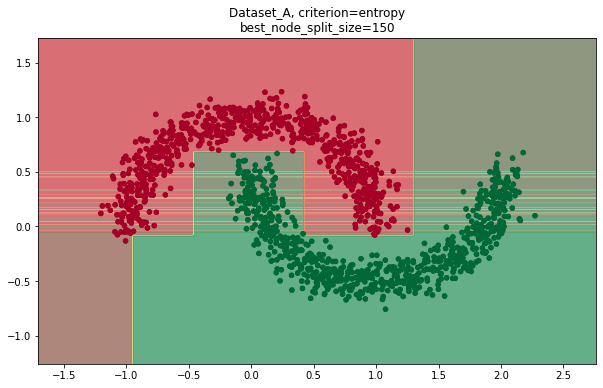

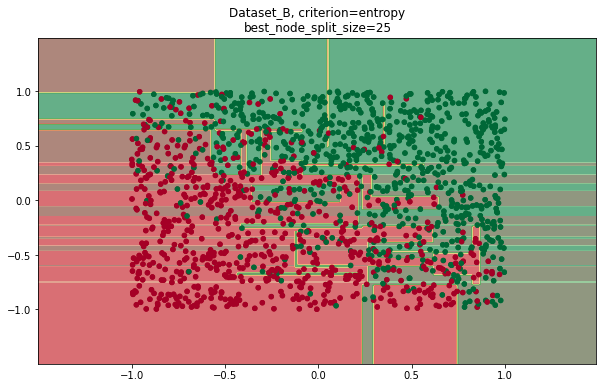

In [ ]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
def plot(X_train, Y_train, trees, title):
    fig, ax = plt.subplots(figsize=(10,6))
    x1 = np.arange(min(X_train[:,0]-0.5),max(X_train[:,0]+0.5),0.01)
    x2 = np.arange(min(X_train[:,1]-0.5),max(X_train[:,1]+0.5),0.01)
    xx1, xx2 = np.meshgrid(x1, x2)
    x_test = np.c_[xx1.ravel(), xx2.ravel()]
    for i in range(2):
        ax.set_title(title[i])
        Y_test_c = decision_tree_classifier(trees[i], x_test)
        ax.contourf(xx1, xx2, Y_test_c.reshape(xx2.shape),alpha=0.4, cmap="RdYlGn")
        ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap="RdYlGn",
                              s=20)
    plt.show()

size_entr = [150,25,64,32]
size_acc = [8,150,250,80]
for i in range (0,2):
    X_train = X_train_t[i]
    Y_train = Y_train_t[i]
    tree1 =  fit_decision_tree(X_train, Y_train, min_num_nodes=size_acc[i], criterion="accuracy")
    tree2 =  fit_decision_tree(X_train, Y_train, min_num_nodes=size_entr[i], criterion="entropy")
    title = ["Dataset_" + str(chr(i+65)) + ", criterion=accuracy\n best_node_split_size="+ str(size_acc[i]),
             "Dataset_" + str(chr(i+65)) + ", criterion=entropy\nbest_node_split_size="+ str(size_entr[i])]
    trees = [tree1, tree2]
    plot(X_train, Y_train, trees, title)

# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [ ]:
# CodeWrite cell
# Write Random Forest classifier. 
def check_purity(data):
    label_column=data[:,-2]
    unique_classes=np.unique(label_column)
    if unique_classes.shape[0]==1:
        return True
    else: 
        return False

def classify_data(data):
    #data is a numpy array with the last column being the label(+1/-1)
    n = data[data[:,-2]==-1]
    p = data[data[:,-2]==1]
    if(p.shape[0]>n.shape[0]):
        return 1
    else:
        return -1
    
def calculate_potential_splits(data,b):
    features_selected = int(b*(data.shape[1] - 2))
    a = np.arange(data.shape[1]-2)
    np.random.shuffle(a)
    b = a[:features_selected]
    potential_splits={}
    for column_index in b:
        values=data[:,column_index]
        max_values=np.max(values)
        min_values=np.min(values)
        diff=(max_values-min_values)/50
        potential_splits[column_index]=[]
        for i in range(1,50):
            split=min_values+diff*i
            potential_splits[column_index].append(split)
    return potential_splits

def split_data(data,feature,threshold):
    feature_column_values=data[:,feature]
    left=data[feature_column_values<=threshold]
    right=data[feature_column_values>threshold]
    return left,right

def calculate_accuracy(left,right):
    wt_vec_left=left[:,-1]
    wt_vec_right=right[:,-1]
    wt_lp=np.sum(wt_vec_left[left[:,-2]==1])
    wt_ln=np.sum(wt_vec_left[left[:,-2]==-1])
    wt_rp=np.sum(wt_vec_right[right[:,-2]==1])
    wt_rn=np.sum(wt_vec_right[right[:,-2]==-1])
    if wt_lp+wt_ln ==0:#case where the left node is does not have any data points
        return max(wt_rp,wt_rn)/(wt_rp+wt_rn)
    elif wt_rp+wt_rn ==0:#case where the  right node does not have any data points
        return max(wt_lp,wt_ln)/(wt_lp+wt_ln)
    else:#case where 
        a = (wt_rp+wt_ln)/(wt_rp+wt_rn+wt_lp+wt_ln)
    accuracy=max(1-a,a)
    return(accuracy)

def calculate_entropy(data):
    #data is a numpy array in which the last column is the label
    wt_vec=data[:,-1]
    wt_pos_vec=wt_vec[data[:,-2]==1]
    wt_neg_vec=wt_vec[data[:,-2]==-1]
    pos_wt=np.sum(wt_pos_vec)
    neg_wt=np.sum(wt_neg_vec)
    if pos_wt==0 or neg_wt==0:
        return 0
    else:
        p = pos_wt/(pos_wt+neg_wt) 
        entropy = (p*np.log(1/p)+(1-p)*np.log((1/(1-p))))
        return (entropy)
           
def calculate_overall_entropy(left,right):
    n=left.shape[0]+right.shape[0]
    entropy=calculate_entropy(left)*(left.shape[0]/n)+calculate_entropy(right)*(right.shape[0]/n)
    return(entropy)

def calculate_best_split(data,potential_splits,criterion='accuracy'):
    #Here potential_splits is a dictionary with key being the feature on which to split. The value corresponding to the key is a list of potential splits values
    min_entropy=1e9
    max_accuracy=-1e9
    for column_index in list(potential_splits.keys()):
        for value in potential_splits[column_index]:
            left,right=split_data(data,column_index,value)
            if criterion=='entropy':
                entropy=calculate_overall_entropy(left,right)  
                if entropy<min_entropy:
                    min_entropy=entropy
                    feature=column_index
                    threshold=value
            elif criterion=='accuracy':
                accuracy=calculate_accuracy(left,right)
                if accuracy>max_accuracy:
                    accuracy=max_accuracy
                    feature=column_index
                    threshold=value
        
    return(feature,threshold)


def  decision_tree_algorithm(data,min_num_nodes=1,criterion='accuracy',counter=0,b=1,max_depth=10000):
#     print(data.shape)
    
    #base case
#     print(min_num_nodes)
    if check_purity(data) or data.shape[0]<=min_num_nodes or counter==max_depth:
        classification=classify_data(data)
        return(classification)
    #recursive part
    else:
        
        counter+=1
        #helper functions
        potential_splits=calculate_potential_splits(data,b)
        feature,threshold=calculate_best_split(data,potential_splits,criterion)
        left,right=split_data(data,feature,threshold)
        #recursive part
        #print(feature)
        #print(threshold)
        node={'feature':feature, 'threshold':threshold,'left': 'none', 'right':'none'}
        
        if left.shape[0]==data.shape[0] or left.shape[0]==0:
            return
        right_tree=decision_tree_algorithm(right,criterion=criterion,counter=counter,min_num_nodes=min_num_nodes)
        left_tree=decision_tree_algorithm(left,criterion=criterion,counter=counter,min_num_nodes=min_num_nodes)
        
        #if right_tree==left_tree:
         #   node=left_tree
        #else:    counter
        node['left']=left_tree
        node['right']=right_tree
        return(node)
    
def fit_decision_tree(X,Y,criterion = 'accuracy',min_num_nodes=1,b=1,max_depth=10000, wt_vec='none'):
    if wt_vec=='none':
        wt_vec=np.ones((X.shape[0],1))
    n_data_points = X.shape[0]
    train_data = np.concatenate((X,Y.reshape(n_data_points,1)),axis=1)
    train_data=np.hstack((train_data,wt_vec))#The weight vector is being added as the last column in train array.
    tree=decision_tree_algorithm(train_data,criterion=criterion,min_num_nodes=min_num_nodes,b=b,max_depth=max_depth)
    return tree
def predict(node,row):
  
  try:
    index = node['feature']
    if row[index] >= node['threshold']:
        if isinstance(node['right'], int):
            return node['right'] 
        else:
            return predict(node['right'], row)
    else:
        if isinstance(node['left'], int):
            return node['left']
        else:
            return predict(node['left'], row)
  except:
    pass

   
def decision_tree_classifier(tree, X_test):
   """ Takes in a tree, and a bunch of instances X and 
   returns the tree predicted values at those instances."""
   Y_pred = np.zeros((X_test.shape[0]))
   for i in range(X_test.shape[0]):
       Y_pred[i] = predict(tree, X_test[i,:])
   return Y_pred 

def fit_random_forest(X, Y, num_trees=10, num_nodes_stop=1,criterion='accuracy', a=0.5, b=0.5, max_depth=10000):
    n = X.shape[0]
    decision_trees = []
    # print("this is fit",max_depth)
    for i in range(num_trees):
        train_data = np.concatenate((X,Y.reshape(n,1)),axis=1)
        np.random.shuffle(train_data)
        X_train = train_data[:int(a*n),0:-1]
        Y_train = train_data[:int(a*n),-1].flatten()
        root = fit_decision_tree(X_train, Y_train,criterion=criterion, min_num_nodes=num_nodes_stop,b=b,max_depth=max_depth)
        decision_trees.append(root)
    return decision_trees #The random forest is returned as a list of dictionaries

def random_forest_classifier(random_forest, X_test):
    #Random Forest is a list of decision trees i.e list of dictionaries
    
    m= X_test.shape[0]
    y_test_pred = np.zeros(m)
    for decision_tree in random_forest:
        y_test_pred = y_test_pred + decision_tree_classifier(decision_tree, X_test)
    y = np.zeros(m)
    y[y_test_pred>=0] = 1
    y[y_test_pred<0] = -1
    return y
    
def accuracy_of_random_forest(random_forest,X_test,Y_test):
    y_test_pred = random_forest_classifier(random_forest, X_test)
    no_correct=np.sum(y_test_pred==Y_test)
    accuracy=no_correct/Y_test.shape[0]
    return accuracy


In [ ]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.
data1 = np.load('dataset_A.npz')
data2 = np.load('dataset_B.npz')
data3 = np.load('dataset_C.npz')
data4 = np.load('dataset_D.npz')
X_train_t = np.array([data1['arr_0'], data2['arr_0'], data3['arr_0'],data4['arr_0']])
Y_train_t = np.array([data1['arr_1'], data2['arr_1'], data3['arr_1'],data4['arr_1']])
X_test_t = np.array([data1['arr_2'], data2['arr_2'], data3['arr_2'],data4['arr_2']])
Y_test_t = np.array([data1['arr_3'], data2['arr_3'], data3['arr_3'],data4['arr_3']])

metric = ['accuracy','entropy']

best_classifier = []

for criterion in metric:
    # print('criterion is ',criterion)
    for i in [0,1,2,3]:
        # print('dataset ',i+1)
        X_train = X_train_t[i]
        Y_train = Y_train_t[i]
        X_test = X_test_t[i]
        Y_test = Y_test_t[i]

        X_tr,Y_tr,X_cv,Y_cv = get_train_val(X_train,Y_train,0.2)
        
        num_trees_range = [1,12,25,32,50,75]
        # num_trees_range = [25,50,75]
        # num_nodes_stop_range = [1]
        num_nodes_stop_range = [1,2,4,8,16,25,32,50,64]
        score = np.zeros((len(num_trees_range),len(num_nodes_stop_range)))
        random_forests = []
        i=0
        for num_trees in num_trees_range:
            j=0
            for num_nodes_stop in num_nodes_stop_range:
                # print('currently running')
                random_forest = fit_random_forest(X_tr, Y_tr, num_trees=num_trees, num_nodes_stop=num_nodes_stop, criterion=criterion, a=0.5, b=0.5)
                score[i,j] = accuracy_of_random_forest(random_forest,X_cv,Y_cv)
                random_forests.append(random_forest)
                j+=1
            i+=1
        ind = np.argmax(score)
        # print(score)
        best_num_trees = num_trees_range[ind//len(num_nodes_stop_range)]
        best_num_nodes = num_nodes_stop_range[ind%len(num_nodes_stop_range)]
        best_random_forest = random_forests[ind]
        test_score = 100*accuracy_of_random_forest(random_forest,X_test,Y_test)
        train_score = 100*accuracy_of_random_forest(random_forest,X_tr,Y_tr)
        # print(train_score,test_score,best_num_nodes,best_num_trees)
        if (criterion=='accuracy'):
            best_classifier.append({'best_forest':best_random_forest,'num_trees':best_num_trees,'num_nodes':best_num_nodes,'test_accuracy':test_score})

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

**Accuracy** | min_node_size |num_trees |train 0/1 error(%) | test 0/1 error(%)
    ---------     |:---: |:---: | :---: | :---: 
**Dataset_A** | 1   | 50 | 0.44 | 9.2
**Dataset_B** | 1 |75 | 2.13|24.2
**Dataset_C** | 1 |12| 0.71  | 9.09
**Dataset_D** | 1  |25| 1.66| 10.65
        
\\

**Entropy** | min_node_size |num_trees |train 0/1 error(%) | test 0/1 error(%)
    ---------     |:---: |:---: | :---: | :---: 
**Dataset_A** | 1   | 25 |0| 0.59
**Dataset_B** | 1 | 25 | 1.77 | 22.39 
**Dataset_C** | 1  |50| 0.35| 5.72
**Dataset_D** | 1  |25| 0.0| 4.14

## Observations:

- We observe again that decision trees have lower errors when entropy is used as a metric as opposed to accuracy  
- The hyperparameter min_num_nodes controls the overfitting of the data. The lower the value, the more the chances of overfitting. Parameters a and b help in controlling bias.  
- We observe that the number of trees in case of accuracy metric is lower than in case of entropy
- On running the algorithm many times, often, we get different choices for best hyperparameters. This is because hyperparameter choosing is done using the cross-validation set, which is chosen randomly. It is this randomness that causes a difference in behaviour everytime the algorithm is run


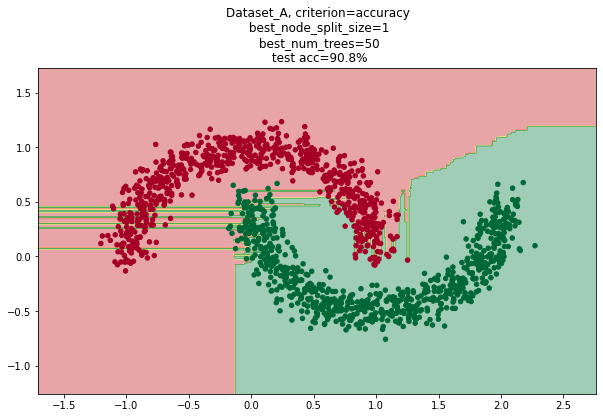

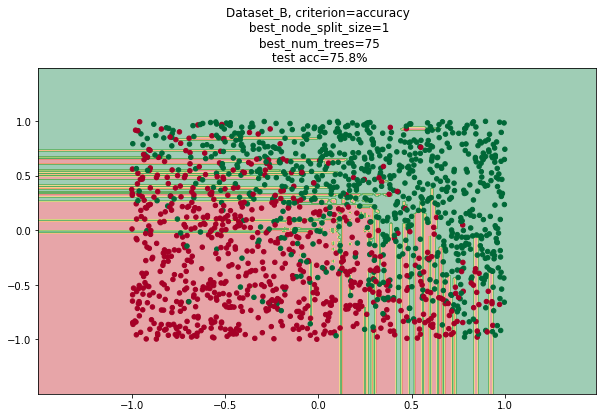

In [ ]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
def plot_2D(X_train, Y_train, forest, title):
    X_pos = X_train[np.nonzero(Y_train==1)] 
    X_neg = X_train[np.nonzero(Y_train==-1)]
    fig, ax = plt.subplots(figsize=(10,6))
    x1 = np.arange(min(X_train[:,0]-0.5),max(X_train[:,0]+0.5),0.01)
    x2 = np.arange(min(X_train[:,1]-0.5),max(X_train[:,1]+0.5),0.01)
    xx1, xx2 = np.meshgrid(x1, x2)
    x_test = np.c_[xx1.ravel(), xx2.ravel()]
    for i in range(1):
        ax.set_title(title[i])
        Y_test_c = random_forest_classifier(forest[i] , x_test)
        ax.contourf(xx1, xx2, Y_test_c.reshape(xx2.shape),alpha=0.4, cmap="RdYlGn")
        ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap="RdYlGn",
                              s=20)
        # ax[i].legend(('+1: green',' -1: red'))
    plt.show()
    return 

for i in range (0,2):
    X_train = X_train_t[i]
    Y_train = Y_train_t[i]
    title = ["Dataset_" + str(chr(i+65)) + ", criterion=accuracy\n best_node_split_size="+ str(best_classifier[i]['num_nodes'])+"\n best_num_trees="+str(best_classifier[i]['num_trees'])+"\n test acc="+str(best_classifier[i]['test_accuracy'])+"%"]
    forest = [best_classifier[i]['best_forest']]
    plot_2D(X_train, Y_train, forest, title)

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs epochs. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [ ]:
# Codewrite cell
# Write code to run here (no plotting)
def fit_adaboost(X_train,Y_train,depth,T):
    n_data_points=X_train.shape[0]
    Y_train=Y_train.reshape((n_data_points,1))
    w=np.ones((X_train.shape[0],1))
    l=np.zeros((X_train.shape[0],1))
    h_s=[]
    beta_s=[]
    #print(Y_train.shape)
    #print(w.shape)
    #print(X_train.shape)
    for t in range(T):
        if t==0:
            h=fit_decision_tree(X_train,Y_train,criterion='entropy',max_depth=depth,min_num_nodes=10)
        else:
            h=fit_decision_tree(X_train,Y_train,criterion='entropy',max_depth=depth,min_num_nodes=10,wt_vec=w)
        h_x=decision_tree_classifier(h, X_train)
        h_x=h_x.reshape((n_data_points,1))
        # print(h_x)
        # print(Y_train)
        z=(np.abs(h_x-Y_train)/2)
        gamma=0.5-np.sum(np.multiply(w,z))/np.sum(w)
        # print('gamma',gamma)
        beta= (0.5+gamma)/(0.5-gamma)
        l=np.abs(h_x-Y_train)/2
        for i in range(w.shape[0]):
            w[i] = w[i]*pow(beta,l[i])
        beta_s.append(beta)
        h_s.append(h)
    return (h_s,beta_s)
def adaboost_classifier(X_test,h_s,beta_s):
    ypred=np.zeros(X_test.shape[0])
    T=len(h_s)
    for i in range(T):
        ypred= ypred + np.log(beta_s[i])*decision_tree_classifier(h_s[i],X_test) 
    ypred=np.sign(ypred)
    return ypred

def calculate_error_adaboost(y_pred,y_test):
    # error=np.abs(y_pred-y_test)/2
    # error=error/y_pred.shape[0]
    # error=error*100
    # return(error)
    return (y_pred!=y_test).sum()/y_pred.shape[0]*100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


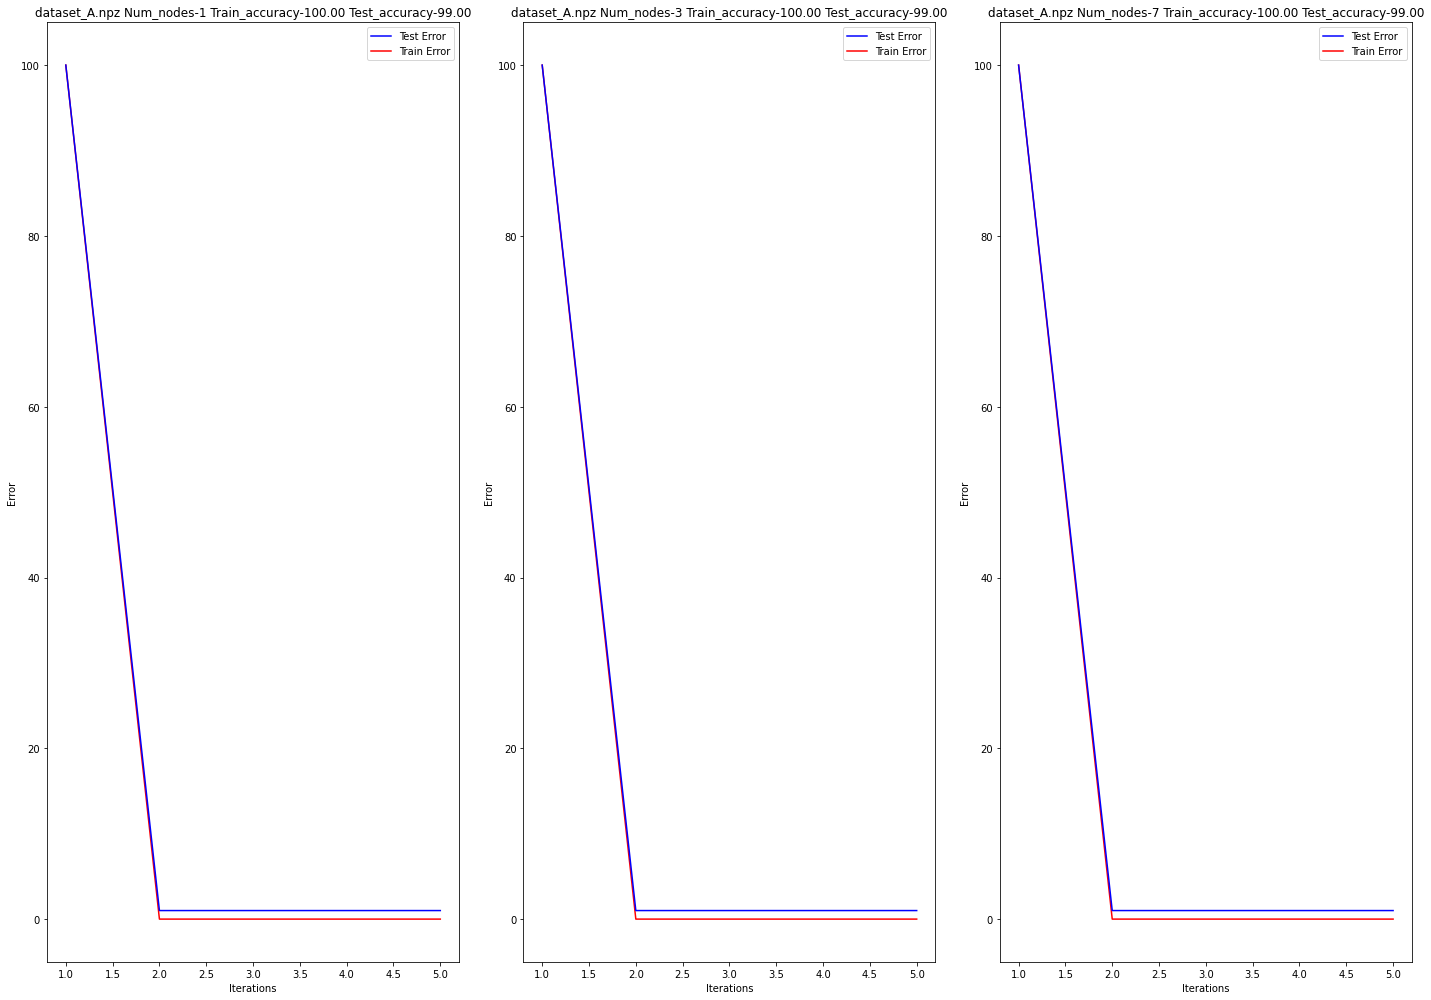

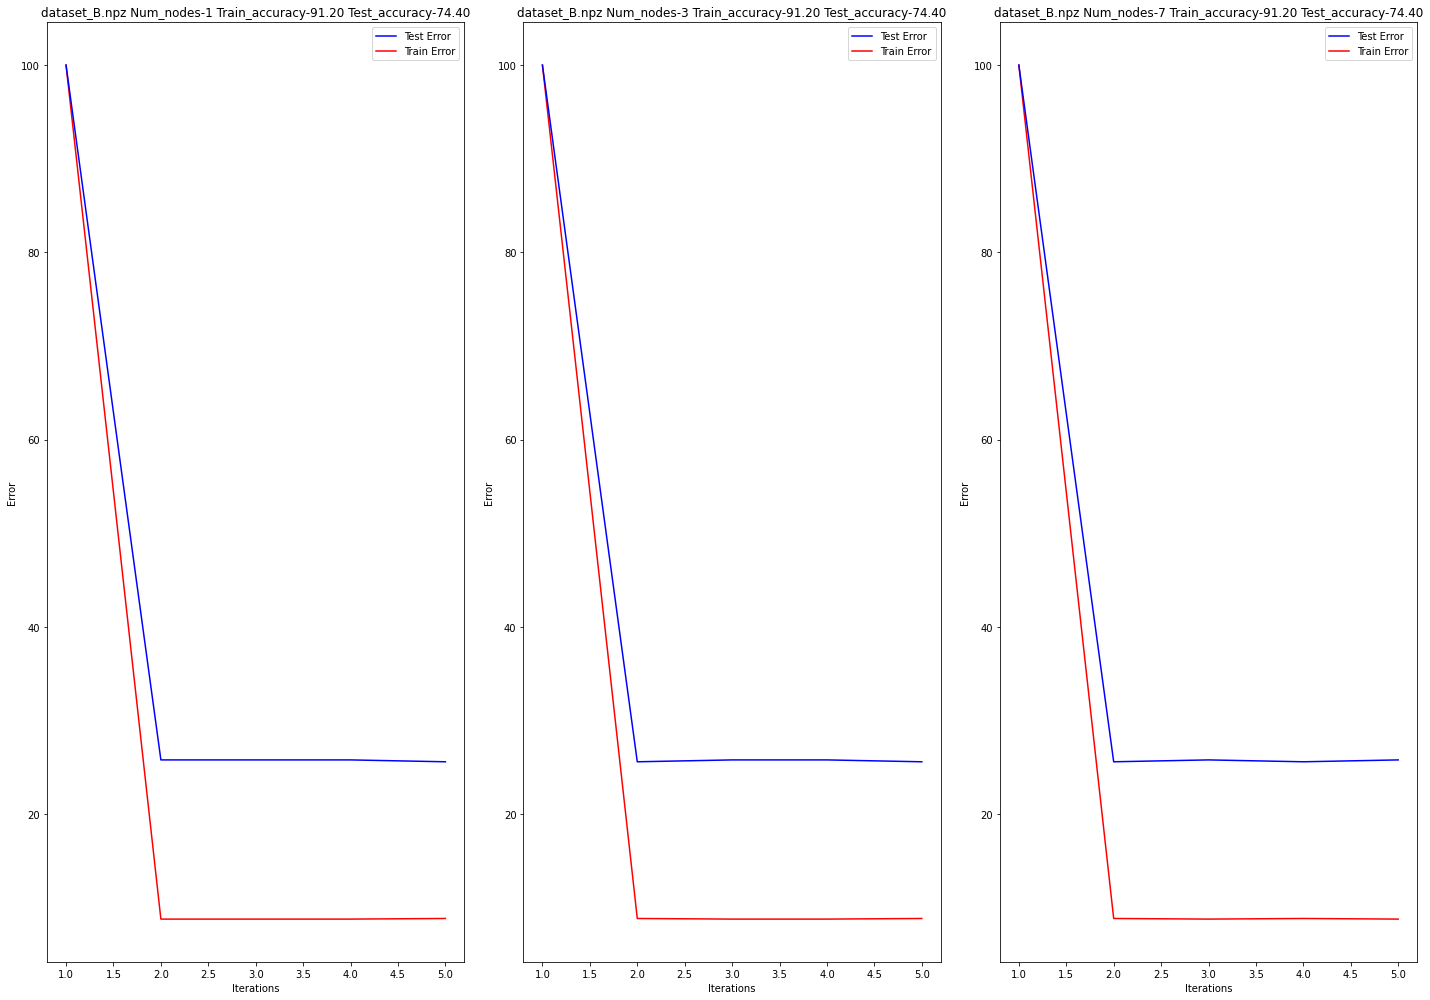

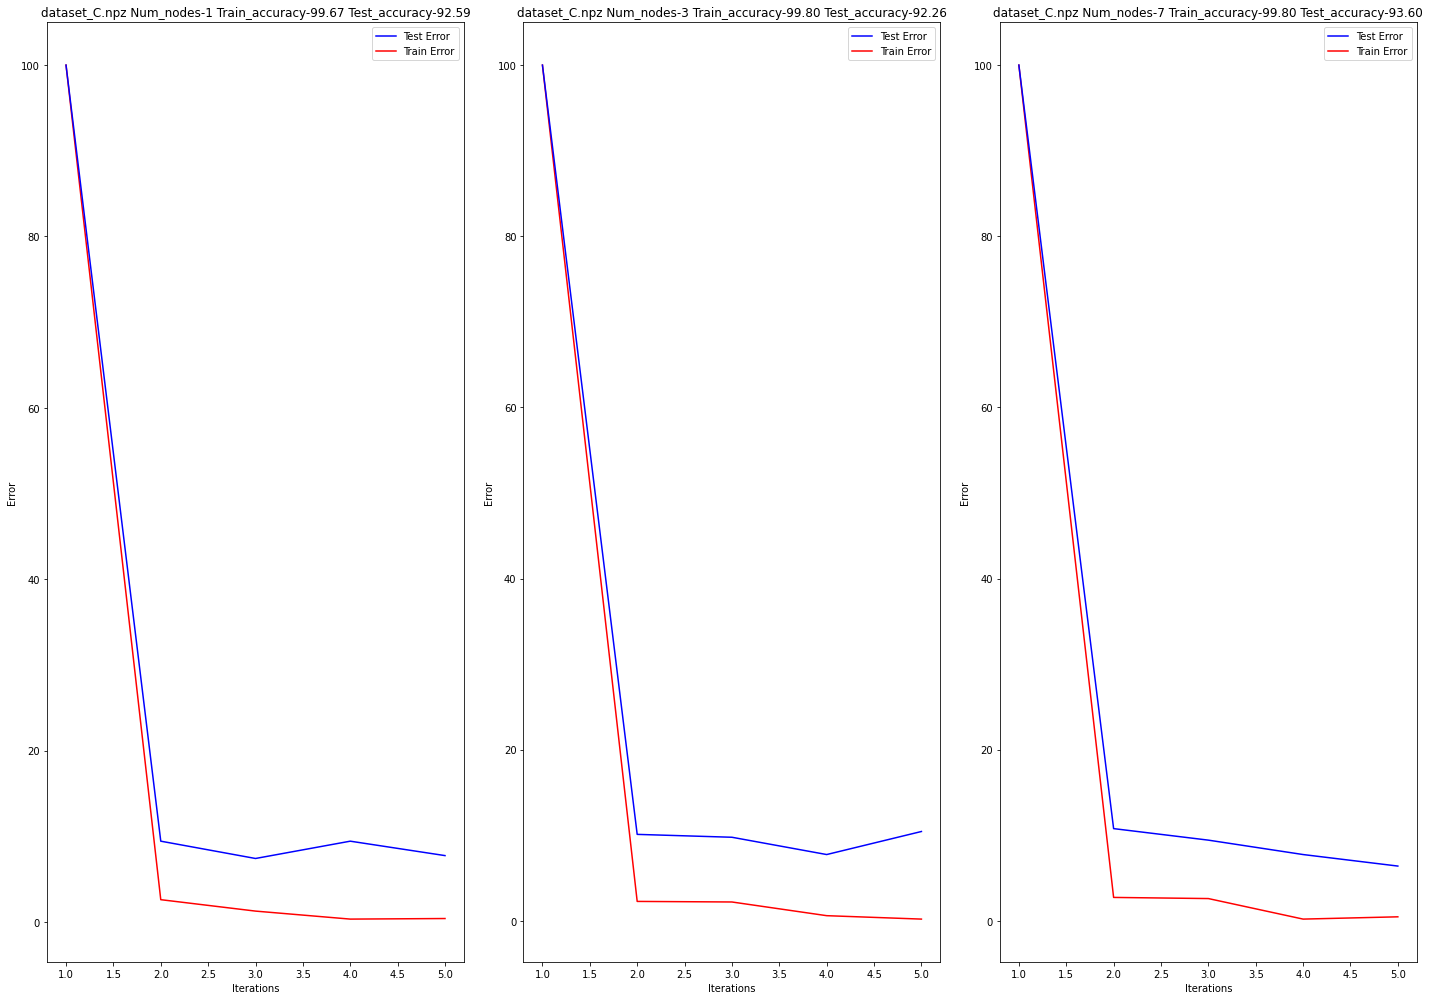

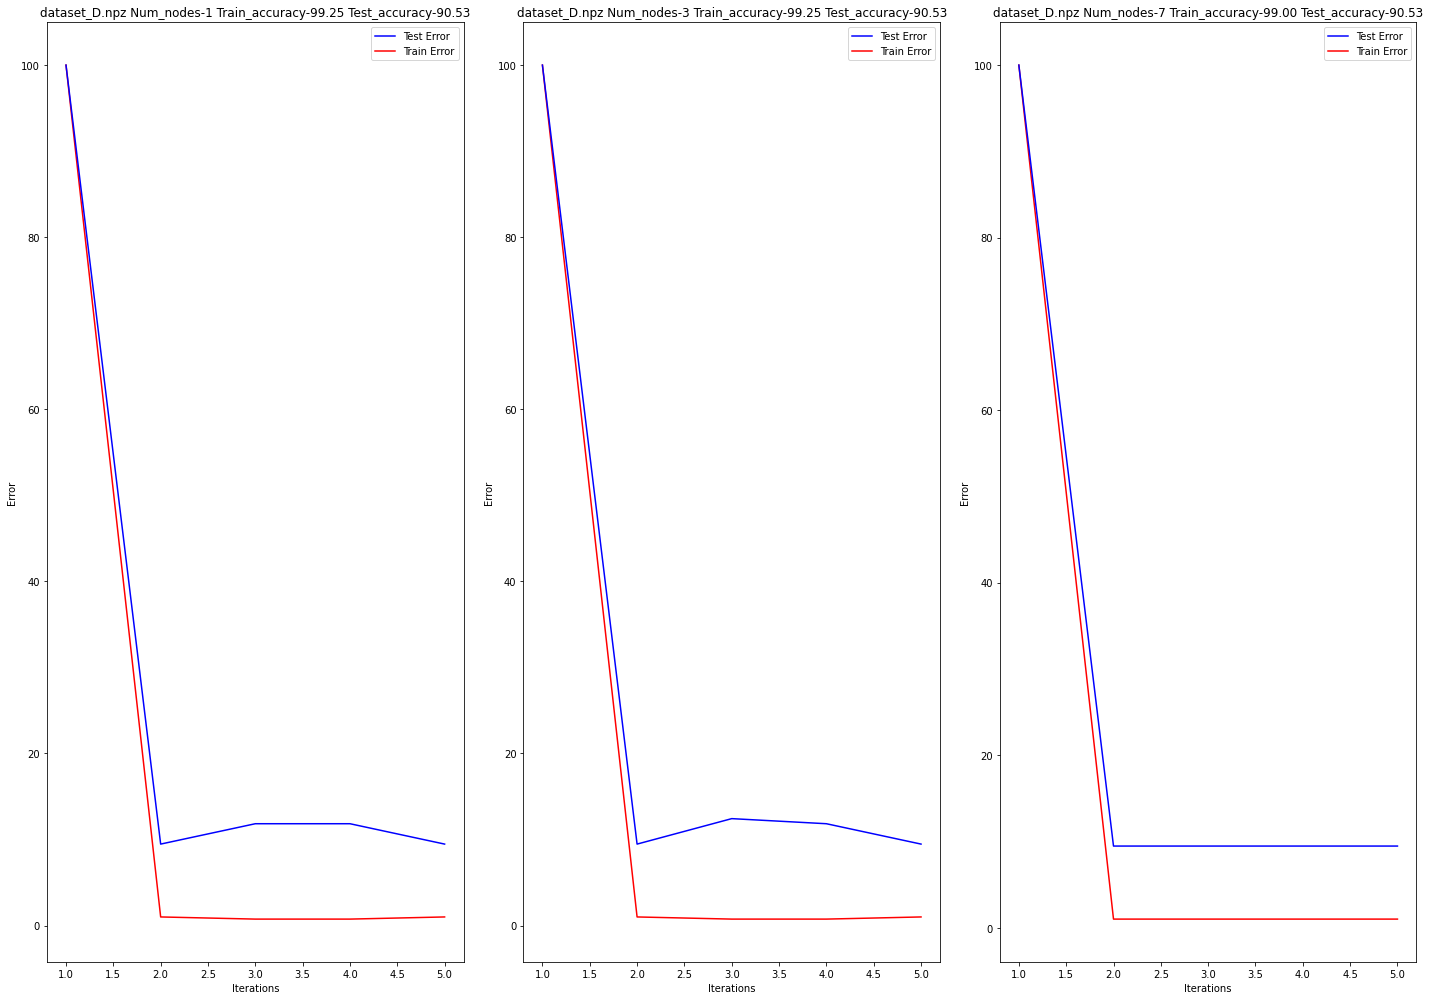

In [ ]:
# Codewrite cell 
# Plots for iteration vs error here
def run_adaboost(X_train, Y_train, X_test, Y_test,depth=1,iters=50):
  ## returns train_error vs iteration,test_error vs iteration
  train_error = []
  test_error = []
  # xtrain,ytrain,x_cv,y_cv = get_train_val(X_train,Y_train,0.2)
  # h_s,beta_s = fit_adaboost(X_train,Y_train,depth=depth,T=iters)
  for i in range(iters):
    h_s,beta_s = fit_adaboost(X_train,Y_train,depth=depth,T=i)
    y_pred_train=adaboost_classifier(X_train,h_s,beta_s)
    y_pred_test=adaboost_classifier(X_test,h_s,beta_s)
    train_e = calculate_error_adaboost(y_pred_train,Y_train)
    test_e = calculate_error_adaboost(y_pred_test,Y_test)
    train_error.append(train_e)
    test_error.append(test_e)
  return train_error,test_error,h_s,beta_s

def plot_error(dataset):
  data =   np.load(dataset)
  num_nodes = [1,3,7]
  fig,axes = plt.subplots(1,3,figsize=(20,14))  
  X_train = data['arr_0']
  Y_train = data['arr_1']
  X_test = data['arr_2']
  Y_test = data['arr_3']
  all_node_h = []
  all_node_beta = []
  for i in range(len(num_nodes)):
    iters = 5
    x_axis = list(range(1,iters+1))
    train_error, test_error,h_s,beta_s = run_adaboost(X_train, Y_train, X_test, Y_test,depth=num_nodes[i],iters=iters)
    all_node_h.append(h_s)
    all_node_beta.append(beta_s)
    axes[i].plot(x_axis,train_error, color="r",label="Train Error")
    axes[i].plot(x_axis,test_error, color="b",label="Test Error")
    axes[i].set_xlabel("Iterations")
    axes[i].set_ylabel("Error")
    axes[i].set_title("{} Num_nodes-{} Train_accuracy-{:.2f} Test_accuracy-{:.2f}".format(dataset,num_nodes[i],100-min(train_error),100-min(test_error)))
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles[::-1], labels[::-1])
    plt.tight_layout()
  plt.show()
  return all_node_h,all_node_beta
all_node_h_A,all_node_beta_A = plot_error("dataset_A.npz")
all_node_h_B,all_node_beta_B = plot_error("dataset_B.npz")
all_node_h_C,all_node_beta_C = plot_error("dataset_C.npz")
all_node_h_D,all_node_beta_D = plot_error("dataset_D.npz")

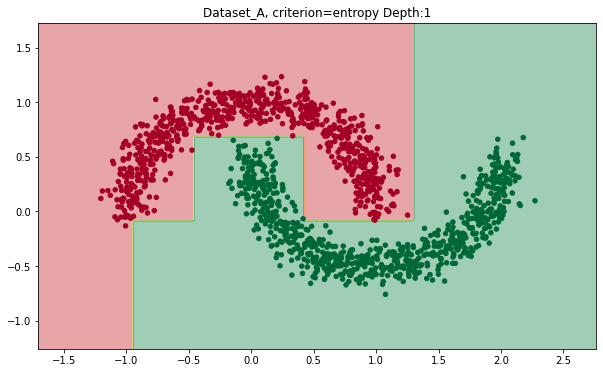

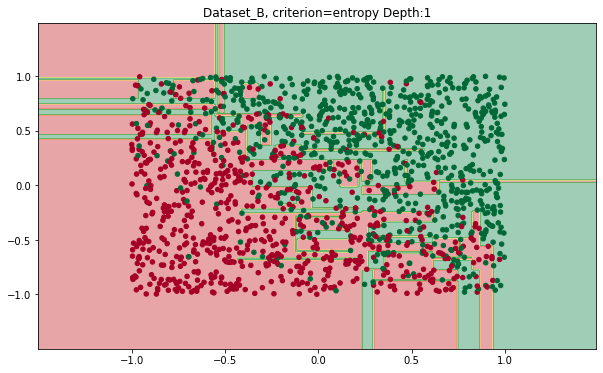

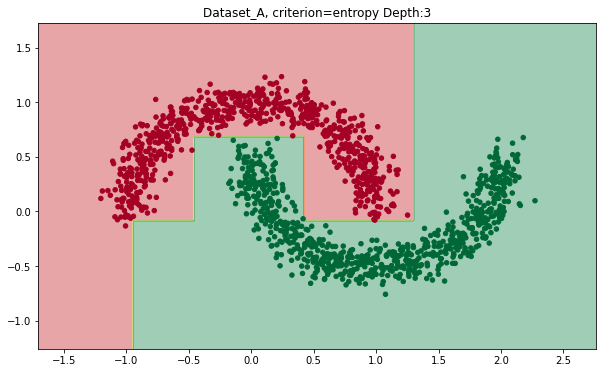

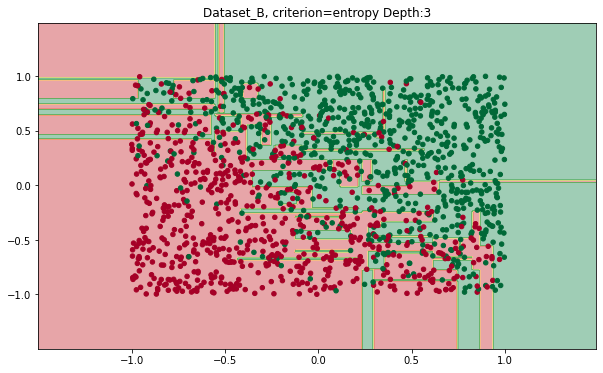

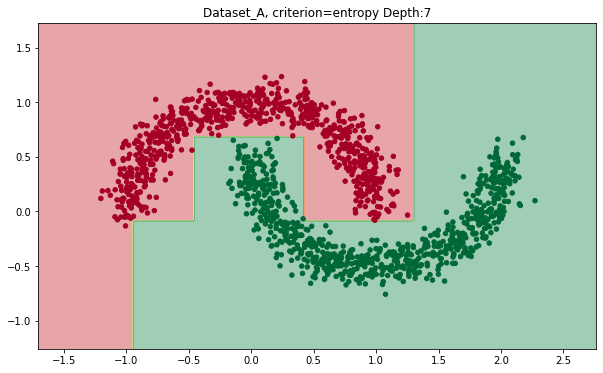

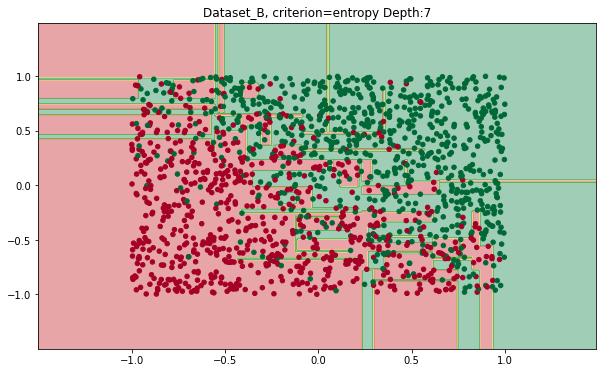

In [ ]:
# Codewrite cell 
# Plots for illustrating the classifier here
def plot_2D(X_train, Y_train, h_s, beta_s, title):
    X_pos = X_train[np.nonzero(Y_train==1)] 
    X_neg = X_train[np.nonzero(Y_train==-1)]
    fig, ax = plt.subplots(figsize=(10,6))
    x1 = np.arange(min(X_train[:,0]-0.5),max(X_train[:,0]+0.5),0.01)
    x2 = np.arange(min(X_train[:,1]-0.5),max(X_train[:,1]+0.5),0.01)
    xx1, xx2 = np.meshgrid(x1, x2)
    x_test = np.c_[xx1.ravel(), xx2.ravel()]
    ax.set_title(title[0])
    Y_test_c = adaboost_classifier(x_test,h_s,beta_s)
    ax.contourf(xx1, xx2, Y_test_c.reshape(xx2.shape),alpha=0.4, cmap="RdYlGn")
    ax.scatter(X_train[:,0], X_train[:,1],c=Y_train, cmap="RdYlGn",
                          s=20)
    # ax.scatter(X_neg[:,0], X_neg[:,1],s=4, color = 'g')
    # ax[i].legend(('+1: green',' -1: red'))
    plt.show()
    return 
num_nodes = [1,3,7]
alphabet = ["A","B","C","D"]
for i in range (0,3):
  
  h_s=[all_node_h_A[i],all_node_h_B[i]]
  beta_s=[all_node_beta_A[i],all_node_beta_B[i]]
  for j in range(0,2):
      X_train = X_train_t[j]
      Y_train = Y_train_t[j]
      title = ["Dataset_" + alphabet[j] + ", criterion=entropy Depth:" + str(num_nodes[i])]
      plot_2D(X_train, Y_train, h_s[j] , beta_s[j], title)

In [ ]:
import pickle
with open ('list_1.txt', 'rb') as fp:
    best_classifier = pickle.load(fp)

*Textwrite* cell:
Observations:
1. After plotting for multiple iteration we observed that the train and test error coverges after the first 3-4 iterations. Therefore we have displayed the results of the train and test accuracy for first 5 iterations.
2. The Fluctuation of the training and test error after convergence is significantly less if entropy is used instead of accuracy. This can possibly be attributed to the smoother function that entropy offers over accuracy. Therefore we have used entropy in our algorithm. 
3. While training the adaboost algorithm, We observed that the value of Beta starts off very high and converges quicky over a few iterations to 1. This indicates that the initial few weak learners had better overall performance than the later few weak learners. This is primarily due to the fact that the weak learners later on cater to very specific sets of wrongly classified data.
4. Increasing the maximum depth of the tree doesn't affect the performance of the adaboost classifier for a given dataset. This is because the weak learners are boosted accordingly to their weaknesses. In theory for a more complex dataset increasing the maximum depth paramater would resulted in faster convergence. However given the dataset at hand is relatively simple we can't observe this. 
5. Dataset B has linearly seperable boundary. But it has a lot of overlap and therfore this noise confuses the adaboost classifier. Therefore the adaboost classifier performs relatively poorly on dataset B. SVM and logistic regression performed better on dataset B compared to tree based algorithms because of this. This is primarily because of a smooth decision boundary that SVM and Logistic regression use.
